# <b> Random Forest Classifier (Attempt 1)</b>
Behold! My first attempt at the Random Forest Classifier for the Diabetes Health Indicator Dataset. 

<b>*Note that you only uncomment the line with pickle if you store the files only locally. They are too large for github and will therefor give error when pushing to main branch.

In [1]:
# All necessary imports
import numpy as np
import pandas as pd
import pickle
from PIL import ImageTk, Image
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer

### <b>Loading the data</b> 
First, the data is loaded and is split between the data (features) and the labels. The data (features) is stored in a dataframe and the labels are stored as a list. 

In [2]:
# Load training data and split labels and features (data)
data = pd.read_csv("./diabetes/training_data(no_pre-diabetes).csv")
labels = data["Diabetes_012"]
del data["Diabetes_012"] # deletes the labels from the data dataframe
print(data.head())

   HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  HeartDiseaseorAttack  \
0     1.0       0.0        1.0  22.0     0.0     0.0                   0.0   
1     1.0       0.0        1.0  33.0     1.0     0.0                   0.0   
2     0.0       0.0        1.0  24.0     1.0     0.0                   0.0   
3     1.0       0.0        1.0  31.0     0.0     0.0                   0.0   
4     1.0       1.0        1.0  32.0     1.0     0.0                   0.0   

   PhysActivity  Fruits  Veggies  ...  AnyHealthcare  NoDocbcCost  GenHlth  \
0           0.0     1.0      1.0  ...            1.0          0.0      3.0   
1           1.0     1.0      1.0  ...            1.0          0.0      2.0   
2           1.0     1.0      1.0  ...            1.0          1.0      3.0   
3           1.0     0.0      1.0  ...            1.0          0.0      1.0   
4           0.0     0.0      1.0  ...            1.0          0.0      2.0   

   MentHlth  PhysHlth  DiffWalk  Sex   Age  Education  Income 

In [3]:
# # Normalize all numeric features by mean normalization
# numeric_features = ["BMI"] # , "GenHlth", "MentHlth", "PhysHlth", "Age", "Education", "Income"
# data[numeric_features] = (data[numeric_features] -data[numeric_features].mean())/data[numeric_features].std()
# print(data.head())

### <b> Split data into training and validation set </b>
Below the data is split up again into training and validation data. with an 80 to 20% ratio

In [4]:
# Split data in training and validation set, with for each a set of data and a set of corresponding labels
training_data, validation_data, training_labels, validation_labels = train_test_split(data, labels, test_size=0.2, random_state=33)

## <b>Create some basic functions that can be used/called later </b>
To avoid a lot of redundancy in the code we created a few functions that can be called whenever it is necesarry. So run these codes ones before you go on with the rest of this notebook.

In [5]:
"""Function to calculate and print all the necessary scores for a model
Negative is the non-diabetes class and Positive the diabetes class"""
def print_multiple_scores(validation_labels, prediction_model):
    # Determine the individual values of the confusion matrix
    tn, fp, fn, tp = confusion_matrix(validation_labels, prediction_model).ravel()

    # Calculate each individual score
    model_sens = tp / (tp + fn)
    model_spec = tn / (tn + fp)
    model_prec = tp / (tp + fp)
    model_fpr = fp / (tn + fp)
    model_npv = tn / (fn + tn)

    # Print all the scores for the user to see
    print("Sensitity (PPV): \t", model_sens)
    print("Specificity (TNR):  ", model_spec)
    print("Precision: \t\t\t", model_prec)
    print("False Positive Rate:", model_fpr)
    print("NPV: \t\t\t\t", model_npv)

## <b>Baseline model </b>
### <b>Fit model without feature selection or hyperparameter tuning</b>
Here a Random Forest Classifier is trained based on just the training data and the default parameters of the function RandomForestClassifier()

In [10]:
base_model = RandomForestClassifier(criterion="entropy").fit(training_data, training_labels)

Now the model is evaluated based on the validation set with the help of sklearn's accuracy_score function:

Accuracy base model:  0.8624337038923681


/usr/local/lib/python3.9/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


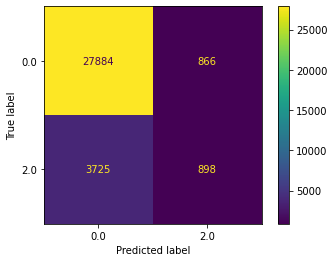

In [6]:
pred_base_model = base_model.predict(validation_data)
print("Accuracy base model: ", accuracy_score(validation_labels, pred_base_model))

plot_confusion_matrix(base_model, validation_data, validation_labels)
plt.show()

In [67]:
# Print scores
print_multiple_scores(validation_labels, pred_base_model)

Sensitity (PPV): 	 0.19424616050183863
Specificity (TNR):   0.9698782608695652
Precision: 			 0.5090702947845805
False Positive Rate: 0.030121739130434783
NPV: 				 0.8821538169508685


Now the model is pickled to be able to use it later:

In [113]:
# pickle.dump(base_model, open("RF_base_model.p","wb"))

## <b> GridSearchCV </b>
To boost the performance of the model, GridSearchCV is performed. Which refers to sampling the data multiple times into training and validation set to determine the best hyperparameters for the model in combination with the given data. 

### <b>Set up the paramater grid</b>
The next piece of code sets the parameter grid for the GridSearchCV later. <br>
Initial search for the right parameters on the internet resulted into the use of default parameters for the following: <br>
<ul>
    <li> bootstrap (default = True) If it would be False then the complete data was used to create the tree.</li> 
    <li> max_features (default = auto) Refers to max_features=sqrt(n_features)</li>
    <li> criterion (default = gini) meaning that the gini impurity is calculated to determine whether to split a node. Gini is faster than entropy calculation and the difference between           them should not be major.</li> 
    <li> max_depth (default = None) Tree kan have as many nodes and edges as seems fit.</li> 
    <li> min_samples_leaf (default = 1, meaning at least one sample needs to be present in the leaf)</li>
</ul>

<b> * Please note that using as many default parameters as possible significantly reduces the training time, which is already quite long for the RF algorithm </b>

In [44]:
# criterion
criterion = ["gini", "entropy"]

# Number of trees in the random forest
n_estimators = [10, 25, 50, 100, 150]
    
# Minimum no. of samples that need to be positive to create a new node split.
min_samples_split = [2, 4, 8, 16, 32, 64]

# Create random_grid
param_grid = {'criterion': criterion,
              'n_estimators': n_estimators,
              'min_samples_split': min_samples_split}

### <b> Initialize model and perform GridSearchCV </b>
Now the Random Forest Classifier is initiated and a gridsearch is started with 4 crossvalidations. 

In [46]:
cv_model = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5)

### <b> Fit the model</b>
Now the model is fitted with the training data and training labels.<br>
<b> *Note that running this piece of code can take quite some time</b>

In [47]:
cv_model.fit(training_data, training_labels)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_split': [2, 4, 8, 16, 32, 64],
                         'n_estimators': [10, 25, 50, 100, 150]})

### <b> Check best parameters and accuracy</b>
Check which parameters where considered the best this round:

Best parameters:  {'criterion': 'gini', 'min_samples_split': 16, 'n_estimators': 100}
Accuracy GridSearchCV model:  0.8671980343391364


/usr/local/lib/python3.9/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


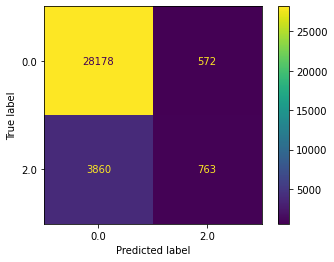

In [48]:
# Print out the best parameters according to GridSearchCV
print("Best parameters: ", cv_model.best_params_)

# Determine accuracy of model based on validation set
pred_cv_model = cv_model.predict(validation_data)
print("Accuracy GridSearchCV model: ", accuracy_score(validation_labels, pred_cv_model))

# Plot confusion matrix
plot_confusion_matrix(cv_model, validation_data, validation_labels)
plt.show()

In [70]:
# Print all scores
print_multiple_scores(validation_labels, pred_cv_model)

Sensitity (PPV): 	 0.16504434349989183
Specificity (TNR):   0.9801043478260869
Precision: 			 0.5715355805243446
False Positive Rate: 0.019895652173913043
NPV: 				 0.8795180722891566


In [118]:
# Pickle model
# pickle.dump(cv_model, open("RF_cv_model.p","wb"))

## <b>Feature selection</b>
To boost the performance of the model, feature selection is performed. 

In [51]:
selection = SelectFromModel(RandomForestClassifier())
f_select_model = selection.fit(training_data, training_labels)

In [52]:
# Determine which features were selected as best
selected_features = training_data.columns[(f_select_model.get_support())]

# Remove non important features from training and validation set
f_select_training_data = training_data[selected_features]
print("Snapshot of training data with important features:", "\n",f_select_training_data.head())

f_select_validation_data = validation_data[selected_features]

# Train model again with selected features
f_model = RandomForestClassifier().fit(f_select_training_data, training_labels)


Snapshot of training data with important features: 
          BMI  GenHlth  MentHlth  PhysHlth   Age  Education  Income
120489  31.0      5.0       0.0      15.0  11.0        5.0     3.0
129057  21.0      3.0       2.0       0.0  13.0        6.0     8.0
48071   32.0      3.0       0.0       0.0   6.0        6.0     8.0
145333  44.0      4.0       5.0      20.0   5.0        4.0     3.0
30240   25.0      1.0       4.0       0.0   3.0        6.0     7.0


Accuracy feature selection model:  0.8457136008150301


/usr/local/lib/python3.9/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


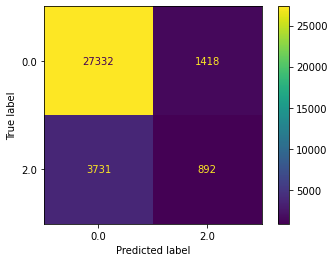

In [53]:
# Determine accuracy of model based on validation set
pred_f_model = f_model.predict(f_select_validation_data)
print("Accuracy feature selection model: ", accuracy_score(validation_labels, pred_f_model))

# Plot confusion matrix
plot_confusion_matrix(f_model, f_select_validation_data, validation_labels)
plt.show()

In [69]:
# Print all scores
print_multiple_scores(validation_labels, pred_f_model)

Sensitity (PPV): 	 0.19294830196841878
Specificity (TNR):   0.9506782608695652
Precision: 			 0.38614718614718613
False Positive Rate: 0.049321739130434784
NPV: 				 0.8798892573157776


In [122]:
# Pickle model
# pickle.dump(f_model, open("RF_feat_select_model.p","wb"))

## <b>Combining the feature selection and GridSearchCV</b>
Let's take a look whether combining these two methods will boost the accuracy.
The param_grid is reused as well as the earlier created data with feature selection.

In [72]:
CVF_model = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5)
CVF_model.fit(f_select_training_data, training_labels)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_split': [2, 4, 8, 16, 32, 64],
                         'n_estimators': [10, 25, 50, 100, 150]})

Below the accuracy is determined for this combined classifier.

Accuracy base model:  0.8633925628502083


/usr/local/lib/python3.9/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


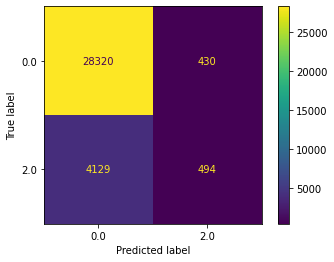

In [73]:
# Determine accuracy of model based on validation set
pred_CVF_model = CVF_model.predict(f_select_validation_data)
print("Accuracy base model: ", accuracy_score(validation_labels, pred_CVF_model))

# Plot confusion matrix
plot_confusion_matrix(CVF_model, f_select_validation_data, validation_labels)
plt.show()

In [74]:
# Print all scores
print_multiple_scores(validation_labels, pred_CVF_model)

Sensitity (PPV): 	 0.10685701925156825
Specificity (TNR):   0.9850434782608696
Precision: 			 0.5346320346320347
False Positive Rate: 0.014956521739130434
NPV: 				 0.8727541680791395


In [125]:
# Pickle model
# pickle.dump(CVF_model, open("RF_combi_CVF_model.p","wb"))

## <b> Further (backward) feature selection </b>
Let's try backward feature selection. Where each iteration the least contributing feature is eliminated from the training data.
Because the base_model did not perform any less than the other tried model we will work with that one here. Meaning we use all the default paramaters for the random forest classifier

In [23]:
# # Split data in training and validation set, with for each a set of data and a set of corresponding labels
# training_data, validation_data, training_labels, validation_labels = train_test_split(data, labels, test_size=0.2, random_state=33)

train_data = training_data.copy()
val_data = validation_data.copy()

In [24]:
base_model = RandomForestClassifier().fit(train_data, training_labels)

In [25]:
pred_model = base_model.predict(val_data)
start_acc = accuracy_score(validation_labels, pred_model)
new_acc = start_acc

print(val_data.head())

        HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
68730      0.0       1.0        1.0  31.0     1.0     0.0   
58807      1.0       1.0        1.0  29.0     0.0     0.0   
37         0.0       0.0        1.0  25.0     0.0     0.0   
166592     0.0       0.0        1.0  31.0     1.0     0.0   
7043       0.0       1.0        1.0  42.0     0.0     0.0   

        HeartDiseaseorAttack  PhysActivity  Fruits  Veggies  ...  \
68730                    0.0           0.0     0.0      1.0  ...   
58807                    0.0           1.0     1.0      1.0  ...   
37                       0.0           1.0     0.0      1.0  ...   
166592                   0.0           0.0     0.0      0.0  ...   
7043                     0.0           1.0     0.0      0.0  ...   

        AnyHealthcare  NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  \
68730             1.0          0.0      5.0       0.0      30.0       1.0   
58807             1.0          0.0      3.0       0.0       5.0       

In [26]:
while start_acc <= new_acc:
    # Store old model and validation data
    prev_model = base_model

    start_acc = new_acc.copy()
    feat_importance = pd.Series(base_model.feature_importances_, index = train_data.columns).sort_values(ascending = True)
    print("Current acc: ", start_acc)
    print("Least contributing feature: ", feat_importance.index[0])
    del train_data[feat_importance.index[0]]
    del val_data[feat_importance.index[0]]

    base_model = RandomForestClassifier().fit(train_data, training_labels)
    pred_model = base_model.predict(val_data)
    new_acc = accuracy_score(validation_labels, pred_model)

    print("New acc: ", new_acc)
    print("--------------------------------------")

    if start_acc > new_acc:
        end_model = prev_model
        val_data = validation_data[feat_importance.index[0:]].copy()
    else:
        end_model = base_model

Current acc:  0.8624037395499355
Least contributing feature:  CholCheck
New acc:  0.8619842387558805
--------------------------------------


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


Accuracy base model:  0.8614748449345279


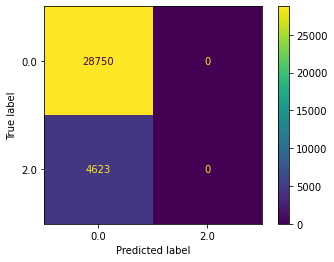

In [27]:
# Determine accuracy of model based on validation set
pred_bf_model = end_model.predict(val_data)
print("Accuracy base model: ", accuracy_score(validation_labels, pred_bf_model))

# Plot confusion matrix
plot_confusion_matrix(end_model, val_data, validation_labels)
plt.show()

In [ ]:
# Print multiple scores
print_multiple_scores(validation_labels, )
